In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [48]:
prp = pd.read_csv('purchases_processed.csv', usecols=['sum_purchase', 'transaction_datetime', 'age', 'gender'])
stats = prp[(prp.age > 0) & (prp.age < 100)].groupby(['transaction_datetime', 'age']).sum_purchase.sum().reset_index()

In [49]:
t1 = stats[stats.transaction_datetime == '2018-12-30'][['age', 'sum_purchase']]
t2 = stats.groupby(['age']).sum_purchase.mean().astype(int).reset_index()

t1 = pd.merge(t1, t2, on='age', how='outer')
t1.columns = ['age', 'sum_new_year', 'sum_usual']
t1['diff'] = t1.sum_new_year - t1.sum_usual
t1['ratio'] = t1.sum_new_year / t1.sum_usual
t1.ratio = t1.ratio.apply(lambda x: min(x, 3))
t1 = t1[['age', 'diff', 'ratio']].set_index('age').reindex(range(101))

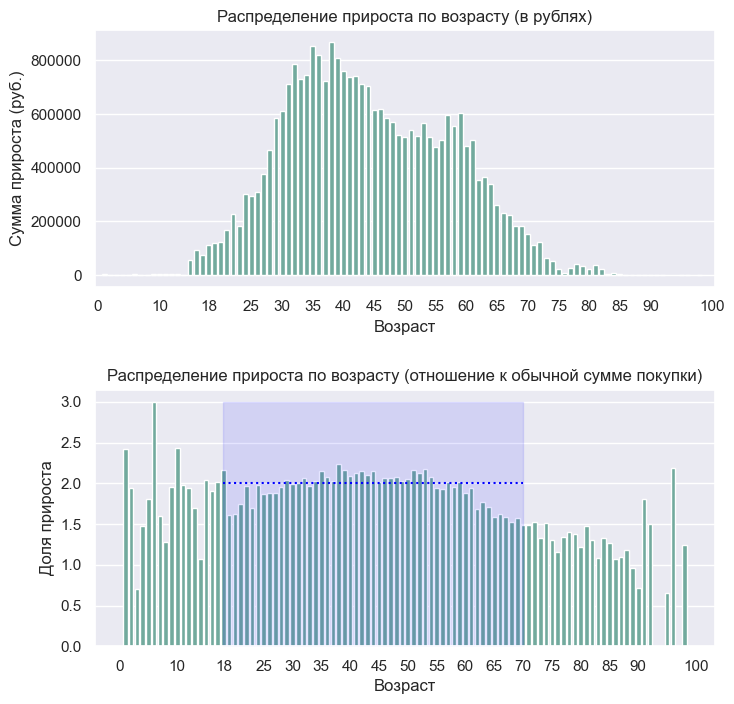

In [55]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(8, 8))

plt.subplot(211)
plt.title("Распределение прироста по возрасту (в рублях)")
sns.barplot(data=t1, x='age', y='diff', color='#69b3a2')
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.xlabel("Возраст")
plt.ylabel("Сумма прироста (руб.)")

plt.subplots_adjust(hspace=0.4)

plt.subplot(212)
plt.title("Распределение прироста по возрасту (отношение к обычной сумме покупки)")
sns.barplot(data=t1, x='age', y='ratio', color='#69b3a2')
plt.hlines(y=2, xmin=18, xmax=70, color='blue', linestyles='dotted')
plt.fill_between(x=[18, 70], y1=[3, 3], color='blue', alpha=0.1)
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.xlabel("Возраст")
plt.ylabel("Доля прироста")

plt.savefig("output.jpg", dpi=500)
plt.show()

In [ ]:

plt.savefig("output.jpg", dpi=500)

In [56]:
prp = pd.read_csv('purchases_processed.csv', usecols=['sum_purchase', 'transaction_datetime', 'age', 'gender'])
prp = prp[(prp.age > 0) & (prp.age < 100)]
t1 = prp.groupby(['transaction_datetime','age']).sum_purchase.sum().reset_index()
t2 = prp.groupby(['transaction_datetime','age']).sum_purchase.count().reset_index()
t3 = prp.groupby(['transaction_datetime','age']).sum_purchase.mean().reset_index()
usual1 = t1.groupby(['age']).sum_purchase.mean().reset_index()
usual1 = usual1[['age', 'sum_purchase']].set_index('age').reindex(range(101)).fillna(0).reset_index()

usual2 = t2.groupby(['age']).sum_purchase.mean().reset_index()
usual2 = usual2[['age', 'sum_purchase']].set_index('age').reindex(range(101)).fillna(0).reset_index()

In [103]:
prp[prp.age == 45].groupby(['transaction_datetime', 'age']).sum_purchase.std().reset_index()

,transaction_datetime,age,sum_purchase
0,2018-11-22,45,450.941059
1,2018-11-23,45,535.571828
2,2018-11-24,45,487.212214
3,2018-11-25,45,476.479055
4,2018-11-26,45,399.555441
...,...,...,...
112,2019-03-14,45,633.215189
113,2019-03-15,45,514.462128
114,2019-03-16,45,525.275413
115,2019-03-17,45,534.388363


<Axes: >

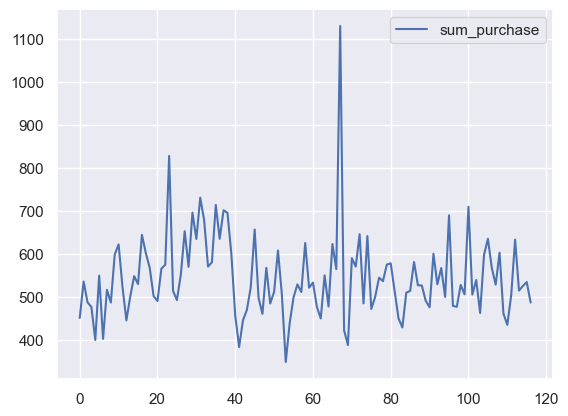

In [98]:
sns.lineplot()

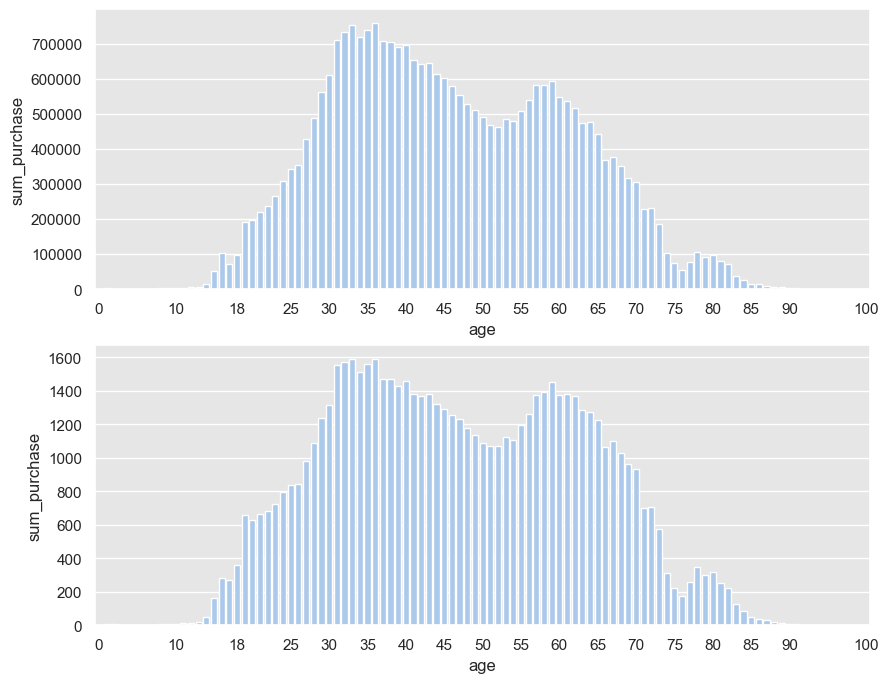

In [51]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
sns.barplot(usual1, x='age', y='sum_purchase')
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.subplot(212)
sns.barplot(usual2, x='age', y='sum_purchase')
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.show()

In [57]:
t3 = pd.merge(t3.groupby('age').sum_purchase.mean().reset_index(), t3.groupby('age').sum_purchase.std().reset_index(), on='age')
t3.columns = ['age', 'sum_purchase_mean', 'sum_purchase_std']
t3 = t3[['age', 'sum_purchase_mean', 'sum_purchase_std']].set_index('age').reindex(range(101)).fillna(0).reset_index()

In [120]:
t3 = prp.groupby(['transaction_datetime', 'age']).agg({'sum_purchase': ['mean', 'std']}).reset_index().fillna(0)
t3.columns = ['transaction_datetime', 'age', 'sum_purchase_mean', 'sum_purchase_std']
t3 = t3.groupby('age')[['sum_purchase_mean', 'sum_purchase_std']].mean().reset_index().reindex(range(101)).fillna(0).astype(int)

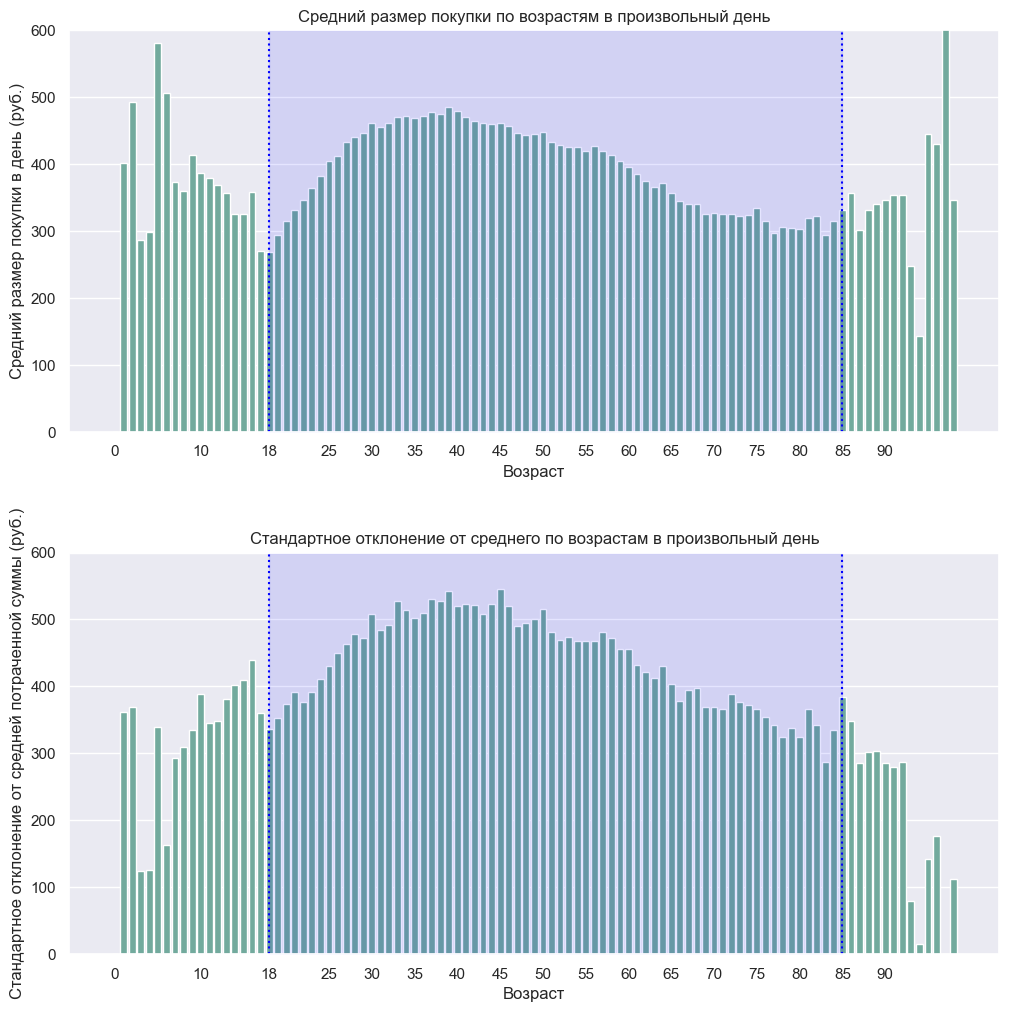

In [128]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 12))

plt.subplot(211)
plt.title("Средний размер покупки по возрастям в произвольный день")
sns.barplot(t3, x='age', y='sum_purchase_mean', color='#69b3a2')
plt.fill_between(x=[18, 85], y1=[600, 600], color='blue', alpha=0.1)
plt.vlines(x=18, ymin=0, ymax=700, color='blue', linestyles='dotted')
plt.vlines(x=85, ymin=0, ymax=700, color='blue', linestyles='dotted')
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.ylim(0, 600)
plt.xlabel("Возраст")
plt.ylabel("Средний размер покупки в день (руб.)")
plt.subplots_adjust(hspace=0.3)
plt.subplot(212)
plt.title("Стандартное отклонение от среднего по возрастам в произвольный день")
sns.barplot(t3, x='age', y='sum_purchase_std', color='#69b3a2')
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.fill_between(x=[18, 85], y1=[600, 600], color='blue', alpha=0.1)
plt.vlines(x=18, ymin=0, ymax=600, color='blue', linestyles='dotted')
plt.vlines(x=85, ymin=0, ymax=600, color='blue', linestyles='dotted')
plt.ylim(0, 600)
plt.xlabel("Возраст")
plt.ylabel("Стандартное отклонение от средней потраченной суммы (руб.)")
plt.savefig("output.jpg", dpi=500)
plt.show()

In [130]:
t3 = prp.groupby(['age']).agg({'sum_purchase': ['mean', 'std']}).reset_index().fillna(0)
t3.columns = ['age', 'sum_purchase_mean', 'sum_purchase_std']
t3 = t3.reindex(range(101)).fillna(0).astype(int)

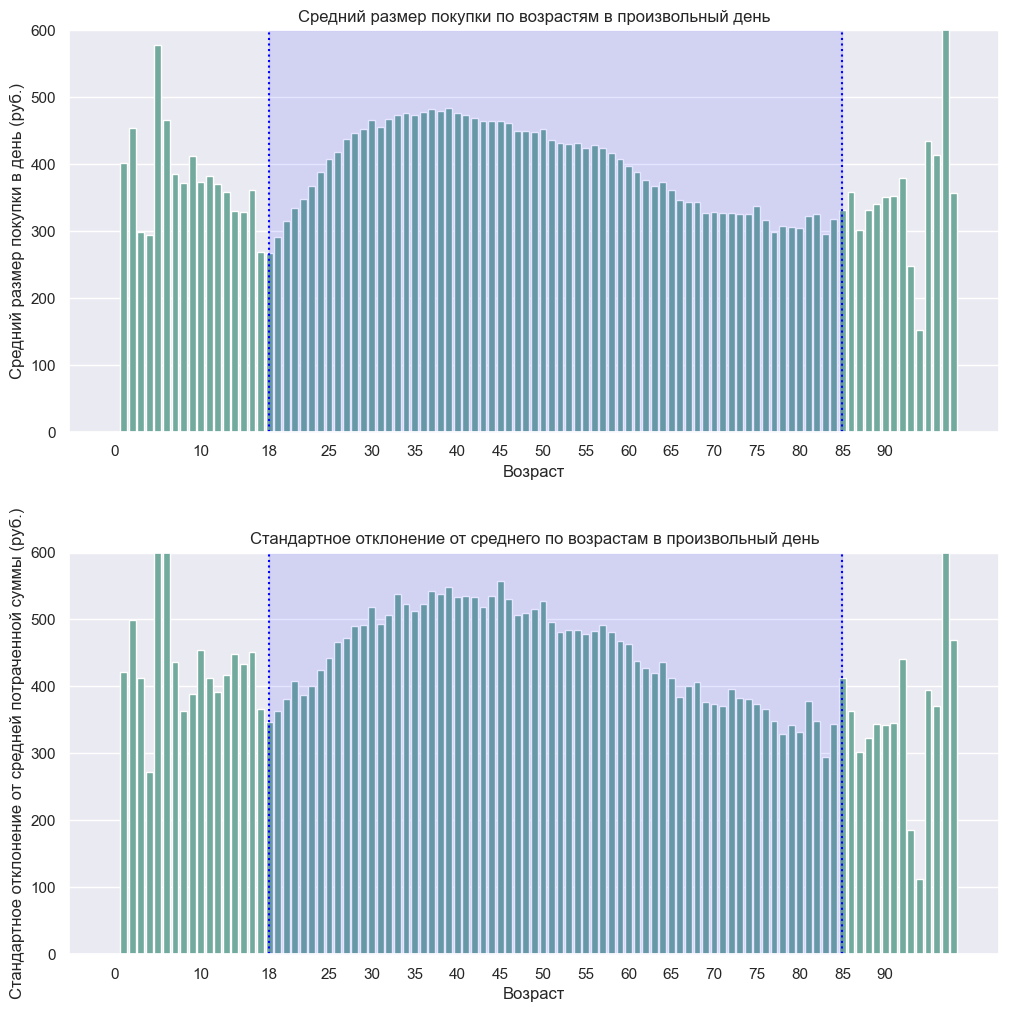

In [132]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 12))

plt.subplot(211)
plt.title("Средний размер покупки по возрастям в произвольный день")
sns.barplot(t3, x='age', y='sum_purchase_mean', color='#69b3a2')
plt.fill_between(x=[18, 85], y1=[600, 600], color='blue', alpha=0.1)
plt.vlines(x=18, ymin=0, ymax=700, color='blue', linestyles='dotted')
plt.vlines(x=85, ymin=0, ymax=700, color='blue', linestyles='dotted')
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.ylim(0, 600)
plt.xlabel("Возраст")
plt.ylabel("Средний размер покупки в день (руб.)")
plt.subplots_adjust(hspace=0.3)
plt.subplot(212)
plt.title("Стандартное отклонение от среднего по возрастам в произвольный день")
sns.barplot(t3, x='age', y='sum_purchase_std', color='#69b3a2')
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.fill_between(x=[18, 85], y1=[600, 600], color='blue', alpha=0.1)
plt.vlines(x=18, ymin=0, ymax=600, color='blue', linestyles='dotted')
plt.vlines(x=85, ymin=0, ymax=600, color='blue', linestyles='dotted')
plt.ylim(0, 600)
plt.xlabel("Возраст")
plt.ylabel("Стандартное отклонение от средней потраченной суммы (руб.)")
plt.savefig("output.jpg", dpi=500)
plt.show()

In [87]:
table = prp[prp.transaction_datetime == '2019-03-08'].groupby('age').agg({'sum_purchase': ['mean', 'std']}).reset_index()
table.columns = ['age', 'sum_purchase_mean', 'sum_purchase_std']
table = table.set_index('age').reindex(range(101)).reset_index().fillna(0).astype(int)

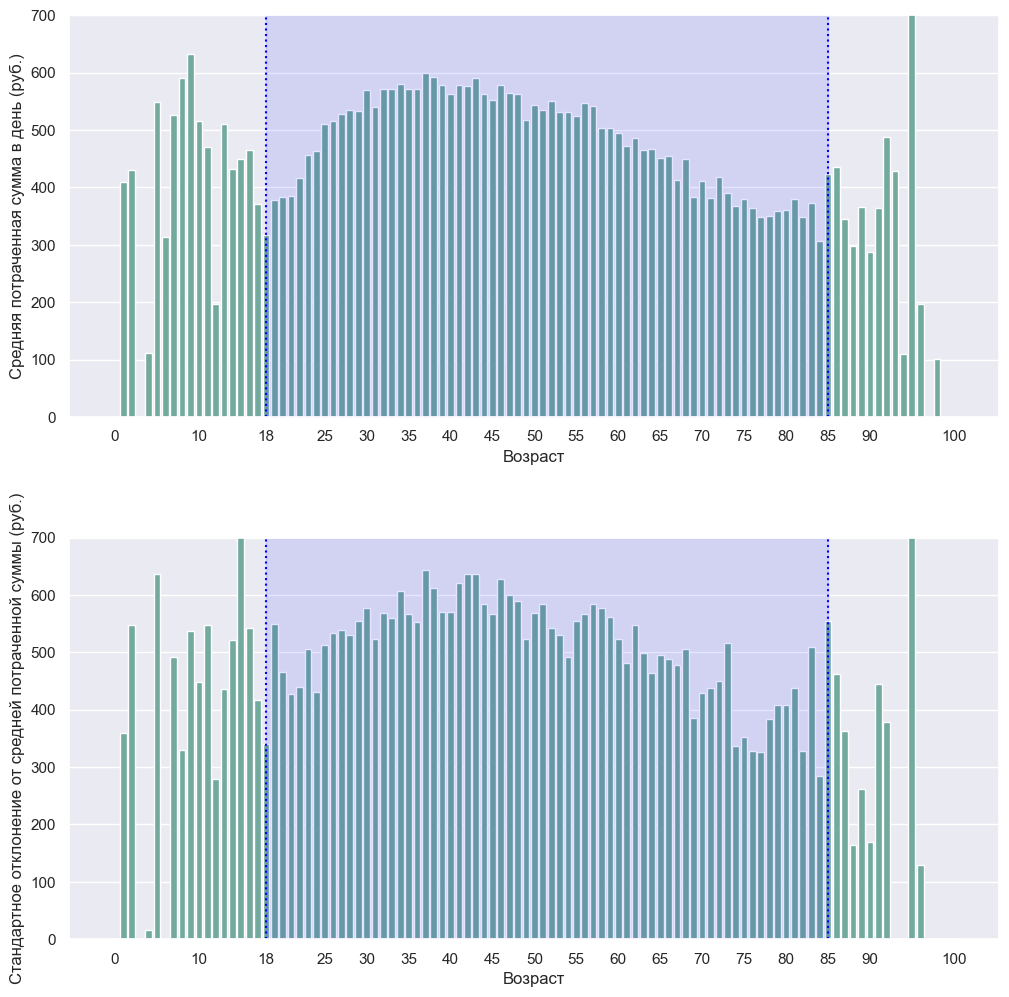

In [94]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 12))

plt.subplot(211)
sns.barplot(table, x='age', y='sum_purchase_mean', color='#69b3a2')
plt.fill_between(x=[18, 85], y1=[700, 700], color='blue', alpha=0.1)
plt.vlines(x=18, ymin=0, ymax=700, color='blue', linestyles='dotted')
plt.vlines(x=85, ymin=0, ymax=700, color='blue', linestyles='dotted')
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.ylim(0, 700)
plt.xlabel("Возраст")
plt.ylabel("Средняя потраченная сумма в день (руб.)")
plt.subplots_adjust(hspace=0.3)
plt.subplot(212)
sns.barplot(table, x='age', y='sum_purchase_std', color='#69b3a2')
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.fill_between(x=[18, 85], y1=[700, 700], color='blue', alpha=0.1)
plt.vlines(x=18, ymin=0, ymax=700, color='blue', linestyles='dotted')
plt.vlines(x=85, ymin=0, ymax=700, color='blue', linestyles='dotted')
plt.ylim(0, 700)
plt.xlabel("Возраст")
plt.ylabel("Стандартное отклонение от средней потраченной суммы (руб.)")

plt.show()

In [ ]:
plt.savefig("output.jpg", dpi=500)

In [186]:
t4 = prp.groupby(['transaction_datetime','age']).sum_purchase.mean().reset_index()
t4 = t4[t4.transaction_datetime > t4.transaction_datetime.min()]

In [91]:
sns.set_theme(style='darkgrid', palette='deep', font_scale=1.2)

c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

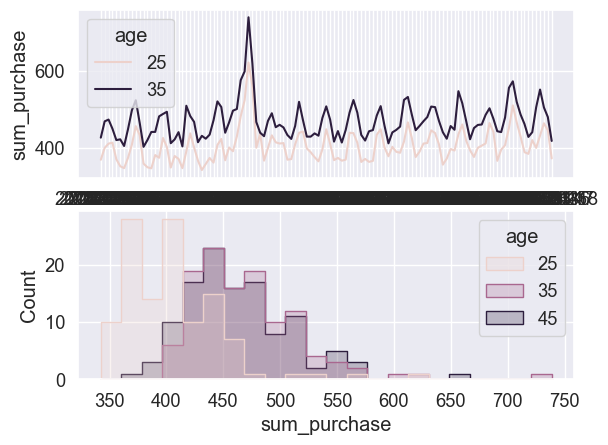

In [94]:
plt.subplot(211)
sns.lineplot(t4[(t4.age == 25) | (t4.age == 35)], x='transaction_datetime', y='sum_purchase', hue='age')
plt.subplot(212)
sns.histplot(t4[(t4.age == 25) | (t4.age == 35) | (t4.age == 45)], x='sum_purchase', hue='age', element="step")
plt.show()

In [ ]:
plt.subplot(211)
sns.lineplot(t4[t4.age == 25], x='transaction_datetime', y='sum_purchase')
plt.subplot(212)
sns.histplot(t4[t4.age == 25], x='sum_purchase')
plt.show()

In [95]:
t4.head()

,transaction_datetime,age,sum_purchase
0,2018-11-21,19,307.0
1,2018-11-21,21,292.0
2,2018-11-21,22,316.5
3,2018-11-21,24,80.0
4,2018-11-21,26,183.0


In [123]:
samples = {}
for el in t4.age.unique():
    if el >= 18 and el <= 60:
        mean = t4[t4.age == el].sum_purchase.mean()
        samples[el] = (t4[t4.age == el].sum_purchase - mean).to_numpy()

In [146]:
from scipy.stats import mannwhitneyu, ks_2samp

In [179]:
mannwhitneyu(samples[24].round(), samples[25].round())

MannwhitneyuResult(statistic=6890.0, pvalue=0.930735501176798)

In [180]:
ks_2samp(samples[21], samples[27])

KstestResult(statistic=0.08547008547008547, pvalue=0.7885416765651418, statistic_location=5.431441366247839, statistic_sign=1)

In [181]:
samples[19].mean(), samples[20].mean()

(8.04067164227669e-14, -2.5020821122492416e-14)

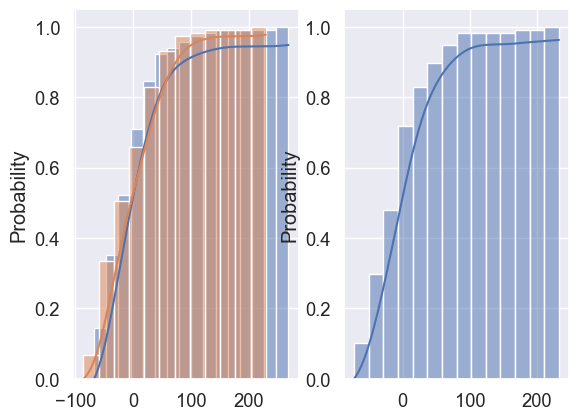

In [182]:
plt.subplot(121)
sns.histplot(samples[35], cumulative=True, stat='probability', kde=True)
sns.histplot(samples[42], cumulative=True, stat='probability', kde=True)
plt.subplot(122)
sns.histplot(samples[26], cumulative=True, stat='probability', kde=True)
plt.show()

In [154]:
y89 = t4[t4.age == 22][['age', 'sum_purchase']]
y89.sum_purchase = y89.sum_purchase - t4[t4.age == 22].sum_purchase.mean()

In [205]:
AGE1 = 28
AGE2 = 29

tt = pd.merge(t4[t4.age == AGE1], t4[t4.age == AGE2], on='transaction_datetime')
tt.columns = ['transaction_datetime', 'AGE1', 'sum_purchase_AGE1', 'AGE2', 'sum_purchase_AGE2']
tt['diff'] = tt.sum_purchase_AGE2 - tt.sum_purchase_AGE1
tt['ratio'] = tt.sum_purchase_AGE2 / tt.sum_purchase_AGE1
tt = tt[['transaction_datetime', 'diff', 'ratio']]

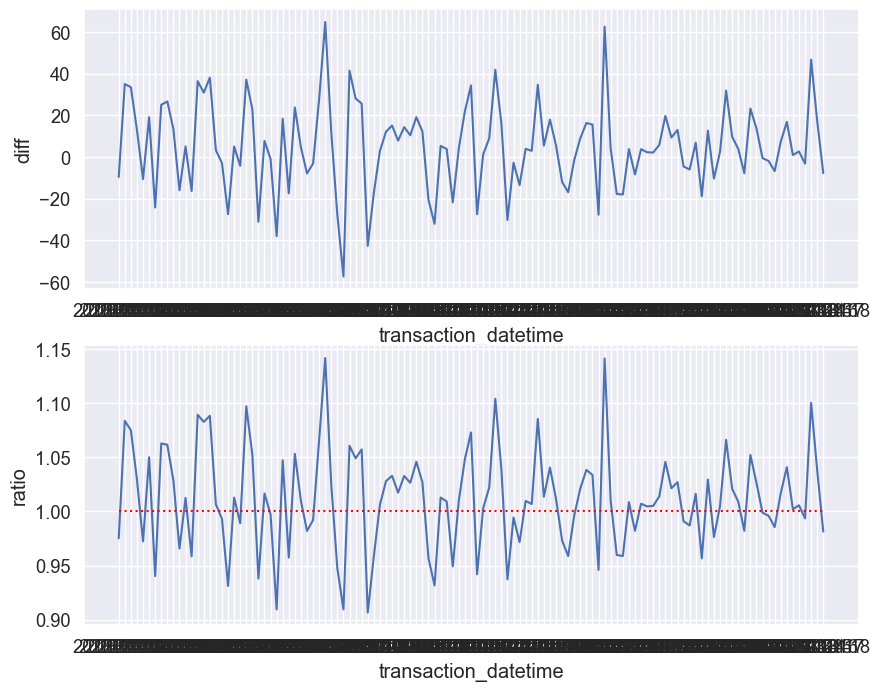

In [206]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
sns.lineplot(tt, x='transaction_datetime', y='diff')
plt.subplot(212)
sns.lineplot(tt, x='transaction_datetime', y='ratio')
plt.hlines(y=1, xmin=tt.transaction_datetime.min(), xmax=tt.transaction_datetime.max(), color='red', linestyles='dotted')
plt.show()

In [214]:
table = pd.merge(t4[t4.age == AGE1][['transaction_datetime', 'sum_purchase']], 
         t4[t4.age == AGE2][['transaction_datetime', 'sum_purchase']],
         on='transaction_datetime')

table.columns = ['transaction_datetime', f'sum_purchase_{AGE1}', f'sum_purchase_{AGE2}']

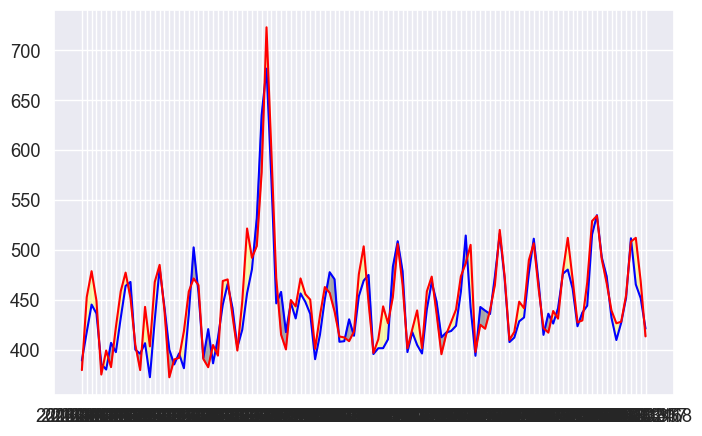

In [218]:
fig, ax = plt.subplots(figsize=(8, 5))
# Add lines
X = table.transaction_datetime
y1 = table.iloc[:, 1]
y2 = table.iloc[:, 2]

ax.plot(X, y1, color='blue')
ax.plot(X, y2, color='red')

# Add fill between the two lines.
# Two `fill_between` calls are needed to have two different colors.
# First, a fill when CAT is larger than NOT_CAT
ax.fill_between(
    X, y1, y2, where=(y1 > y2), 
    interpolate=True, color='black', alpha=0.3
)

ax.fill_between(
    X, y1, y2, where=(y1 <= y2),
    interpolate=True, color='yellow', alpha=0.3
)

In [133]:
prp = pd.read_csv('purchases_processed.csv', usecols=['sum_purchase', 'transaction_datetime', 'age', 'gender'])

In [139]:
list1 = [prp.groupby(['transaction_datetime']).sum_purchase.sum().mean().astype(int),
              prp[prp.transaction_datetime == '2018-12-30'].sum_purchase.sum()]
list2 = [prp.groupby(['transaction_datetime']).sum_purchase.count().mean().astype(int),
              prp[prp.transaction_datetime == '2018-12-30'].sum_purchase.count()]

In [ ]:
plt.subplot(211)
plt.title("Средний размер покупки по возрастям в произвольный день")
sns.barplot(t3, x='age', y='sum_purchase_mean', color='#69b3a2')
plt.fill_between(x=[18, 85], y1=[600, 600], color='blue', alpha=0.1)
plt.vlines(x=18, ymin=0, ymax=700, color='blue', linestyles='dotted')
plt.vlines(x=85, ymin=0, ymax=700, color='blue', linestyles='dotted')
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.ylim(0, 600)
plt.xlabel("Возраст")
plt.ylabel("Средний размер покупки в день (руб.)")
plt.subplots_adjust(hspace=0.3)

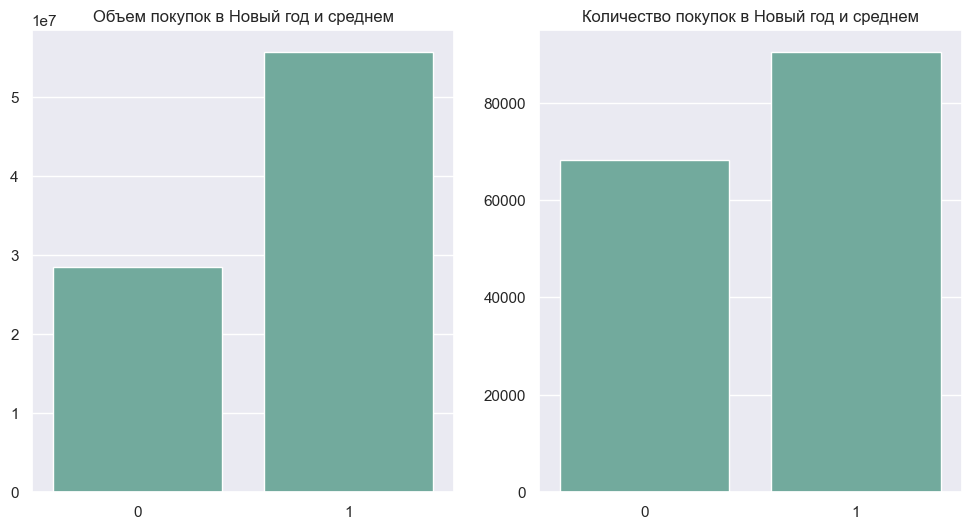

In [141]:

sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Объем покупок в Новый год и среднем")
sns.barplot(list1, color='#69b3a2')
plt.subplot(122)
plt.title("Количество покупок в Новый год и среднем")
sns.barplot(list2, color='#69b3a2')
plt.show()

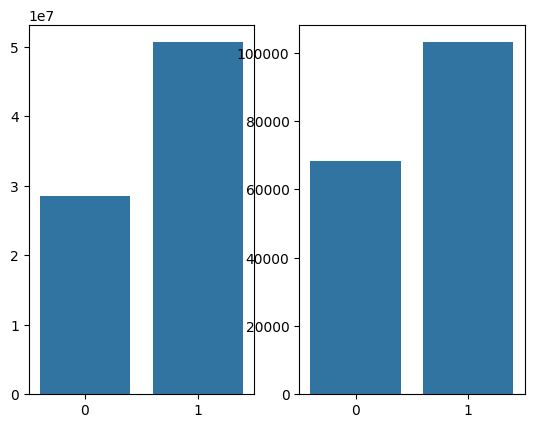

In [19]:
plt.subplot(121)
sns.barplot([prp.groupby(['transaction_datetime']).sum_purchase.sum().mean().astype(int),
              prp[prp.transaction_datetime == '2019-03-07'].sum_purchase.sum()])
plt.subplot(122)
sns.barplot([prp.groupby(['transaction_datetime']).sum_purchase.count().mean().astype(int),
              prp[prp.transaction_datetime == '2019-03-07'].sum_purchase.count()])
plt.show()

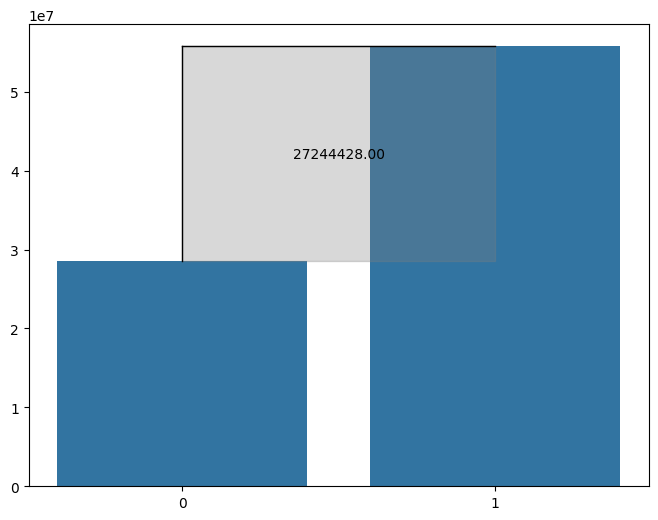

In [97]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(list1)

# Получение координат вершин столбцов
bars = ax.patches

# Создание аннотаций
for i in range(len(bars)-1):
    height1 = bars[i].get_height()
    height2 = bars[i+1].get_height()
    diff = height2 - height1

    # Определение координат аннотации
    x1 = bars[i].get_x() + bars[i].get_width() / 2
    x2 = bars[i+1].get_x() + bars[i+1].get_width() / 2

    # Рисование линий
    ax.plot([x1, x1], [height1, height1 + diff], color='black', linewidth=1)
    ax.plot([x1, x2], [height1 + diff, height1 + diff], color='black', linewidth=1)
    ax.plot([x2, x2], [height2, height1 + diff], color='black', linewidth=1)
    
    # Рисование заполненного пространства между линиями
    ax.fill_between([x1, x2], height1, height2, color='grey', alpha=0.3)

    # Добавление текста аннотации
    ax.text((x1 + x2) / 2, height1 + diff / 2, f'{diff:.2f}', ha='center', va='center')

# Отображение графика
plt.show()

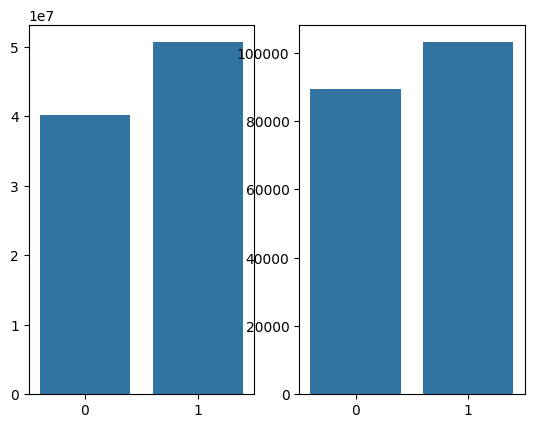

In [23]:
plt.subplot(121)
sns.barplot([prp[prp.transaction_datetime == '2019-03-02'].sum_purchase.sum(),
              prp[prp.transaction_datetime == '2019-03-07'].sum_purchase.sum()])
plt.subplot(122)
sns.barplot([prp[prp.transaction_datetime == '2019-03-01'].sum_purchase.count().mean().astype(int),
              prp[prp.transaction_datetime == '2019-03-07'].sum_purchase.count()])
plt.show()

In [40]:
t1 = prp.groupby(['transaction_datetime', 'gender']).sum_purchase.sum().reset_index()
t2 = prp.groupby(['transaction_datetime', 'gender']).sum_purchase.count().reset_index()
t1 = t1.groupby(['gender']).sum_purchase.mean().astype(int).reset_index()
t2 = t2.groupby(['gender']).sum_purchase.mean().astype(int).reset_index()
t1 = pd.merge(t1, prp[prp.transaction_datetime == '2019-03-08'].groupby('gender').sum_purchase.sum(), on='gender')
t1.columns = ['gender', 'sum_purchase_usual', 'sum_purchase_0803']
t2 = pd.merge(t2, prp[prp.transaction_datetime == '2019-03-08'].groupby('gender').sum_purchase.count(), on='gender')
t2.columns = ['gender', 'sum_purchase_usual', 'sum_purchase_0803']
t1 = pd.melt(t1, id_vars=['gender'], value_vars=['sum_purchase_usual', 'sum_purchase_0803'])
t2 = pd.melt(t2, id_vars=['gender'], value_vars=['sum_purchase_usual', 'sum_purchase_0803'])

In [46]:
t2

,gender,variable,value
0,F,sum_purchase_usual,26552
1,M,sum_purchase_usual,11748
2,U,sum_purchase_usual,29879
3,F,sum_purchase_0803,31760
4,M,sum_purchase_0803,18195
5,U,sum_purchase_0803,40489


c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

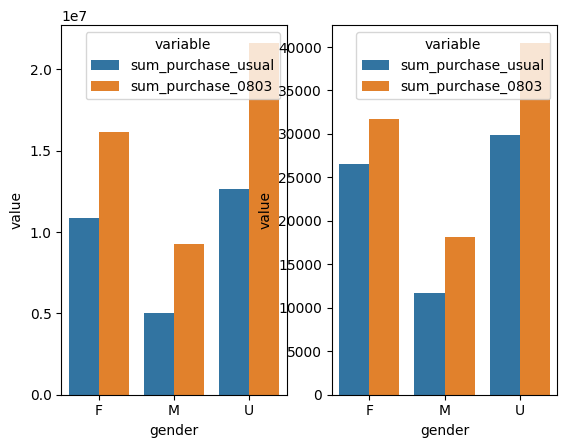

In [47]:
plt.subplot(121)
sns.barplot(t1, x='gender', y='value', hue='variable')
plt.subplot(122)
sns.barplot(t2, x='gender', y='value', hue='variable')
plt.show()

In [50]:
t1 = prp.groupby(['transaction_datetime', 'gender']).sum_purchase.sum().reset_index()
t2 = prp.groupby(['transaction_datetime', 'gender']).sum_purchase.count().reset_index()
t1 = t1.groupby(['gender']).sum_purchase.mean().astype(int).reset_index()
t2 = t2.groupby(['gender']).sum_purchase.mean().astype(int).reset_index()
t1 = pd.merge(t1, prp[prp.transaction_datetime == '2019-03-08'].groupby('gender').sum_purchase.sum(), on='gender')
t1.columns = ['gender', 'sum_purchase_usual', 'sum_purchase_0803']
t2 = pd.merge(t2, prp[prp.transaction_datetime == '2019-03-08'].groupby('gender').sum_purchase.count(), on='gender')
t2.columns = ['gender', 'sum_purchase_usual', 'sum_purchase_0803']

In [53]:
t1 ['ratio'] = t1.sum_purchase_0803 / t1.sum_purchase_usual
t2 ['ratio'] = t2.sum_purchase_0803 / t2.sum_purchase_usual

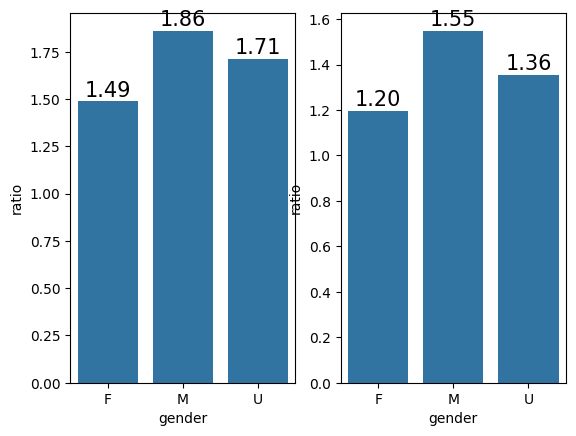

In [84]:
plt.subplot(121)
plots = sns.barplot(t1, x='gender', y='ratio')


for bar in plots.patches:
  
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    

plt.subplot(122)
plots2 = sns.barplot(t2, x='gender', y='ratio')

for bar in plots2.patches:
  
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots2.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()

In [55]:
pd.read_csv('purchases_processed.csv', nrows=1)

,client_id,transaction_id,transaction_datetime,sum_purchase,first_issue_date,age,gender,time_since_card,time_purchase_to_now,weeks_since_card
0,000012768d,6a0e96d0bc,2019-03-08,804,2017-08-05,45,U,more_than_90_days,30_days,82


In [38]:
prp = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime'])

In [40]:
coverage = prp.groupby('transaction_datetime').client_id.nunique().reset_index()

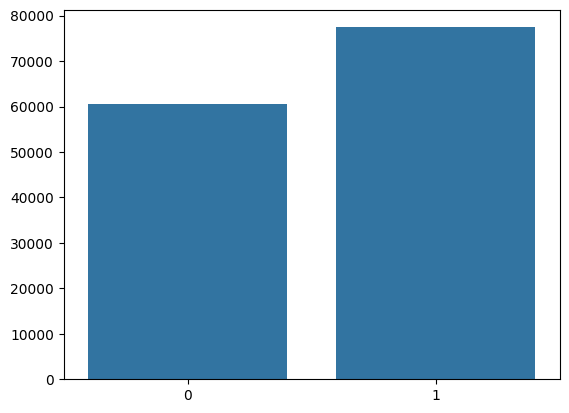

In [41]:
sns.barplot([coverage.client_id.mean().astype(int), coverage[coverage.transaction_datetime == '2018-12-30'].client_id.sum()])
plt.show()

In [42]:
coverage['ratio'] = coverage.client_id / coverage.client_id.mean().astype(int)

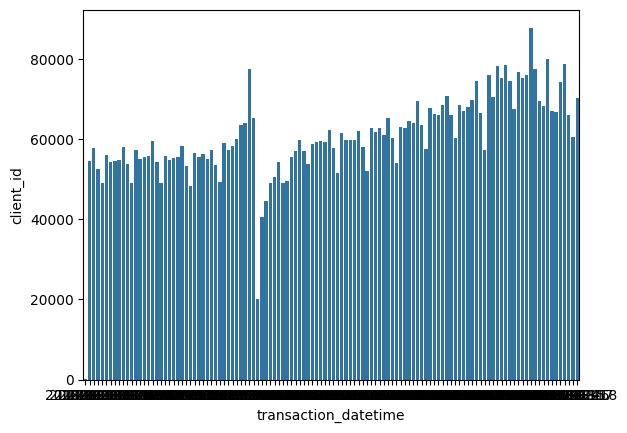

In [43]:
sns.barplot(coverage, x='transaction_datetime', y='client_id')
plt.show()

In [44]:
coverage.sort_values(by='ratio', ascending=False).head(10)

,transaction_datetime,client_id,ratio
106,2019-03-07,87909,1.451698
110,2019-03-11,80023,1.321471
114,2019-03-15,78891,1.302778
100,2019-03-01,78657,1.298913
98,2019-02-27,78385,1.294422
107,2019-03-08,77586,1.281227
39,2018-12-30,77447,1.278932
103,2019-03-04,76821,1.268594
105,2019-03-06,76015,1.255284
96,2019-02-25,75969,1.254525


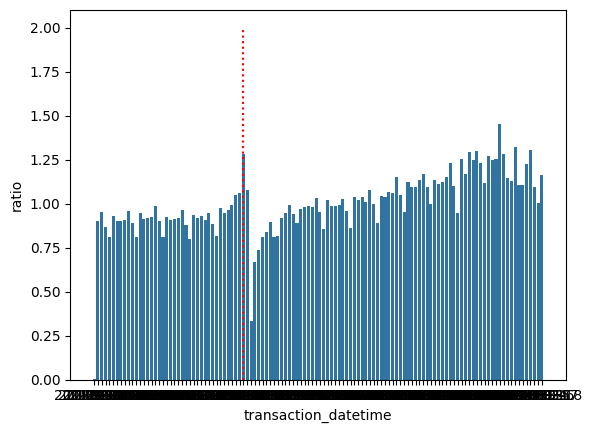

In [45]:
sns.barplot(coverage, x='transaction_datetime', y='ratio')
plt.vlines(x='2018-12-30', ymin=0, ymax=2, color='red', linestyles='dotted')
plt.show()

In [48]:
prp['day_of_week'] = prp.transaction_datetime.astype('timestamp[us][pyarrow]').dt.day_of_week
dd = prp.groupby('day_of_week').client_id.nunique().reset_index()
dd['day_of_week'] = dd.day_of_week.apply(lambda x: calendar.day_name[x])

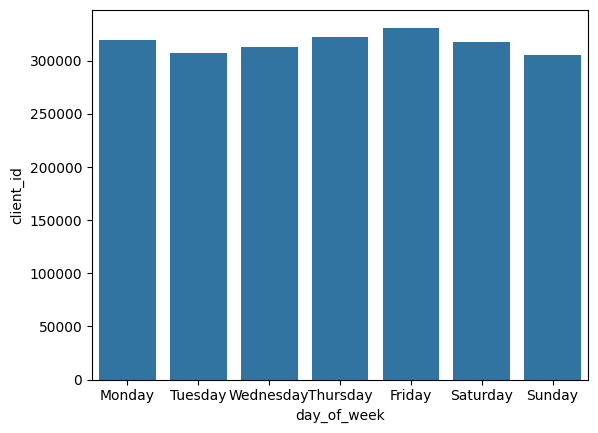

In [51]:
sns.barplot(dd, x='day_of_week', y='client_id')
plt.show()

In [61]:
df = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase'])
df = df.groupby('transaction_datetime').agg({'client_id':['count', 'nunique'], 'sum_purchase': ['sum']})
df.columns = ['num_sales', 'coverage', 'sales']
df = df.reset_index()

In [62]:
df.head()

,transaction_datetime,num_sales,coverage,sales
0,2018-11-21,32,30,12287
1,2018-11-22,61181,54584,22939946
2,2018-11-23,65383,57777,26915424
3,2018-11-24,60016,52533,25730608
4,2018-11-25,55527,49177,22362587


In [67]:
df['sales_by_coverage'] = df['sales'] / df['coverage']

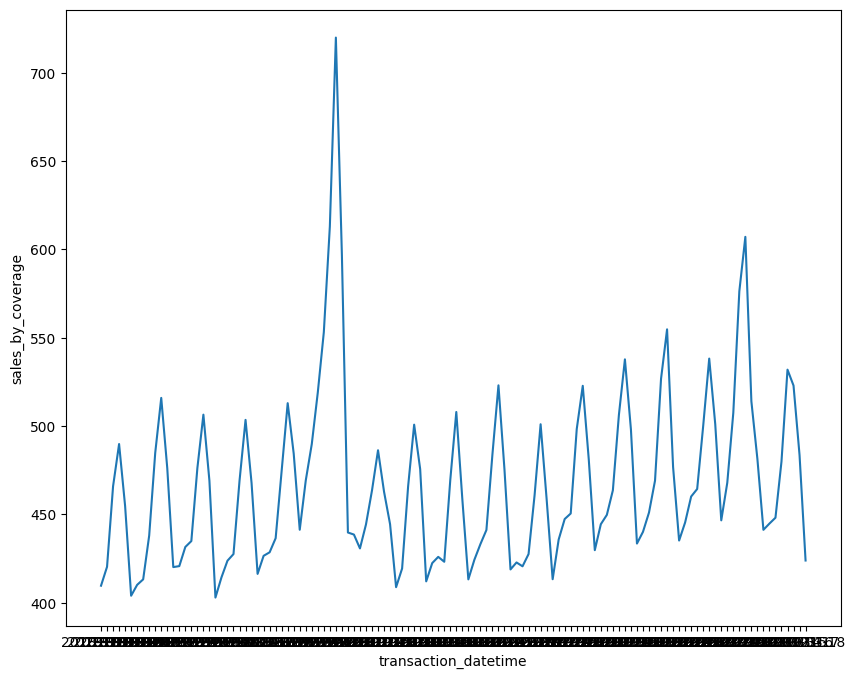

In [68]:
plt.figure(figsize=(10, 8))
sns.lineplot(df, x='transaction_datetime', y='sales_by_coverage')
plt.show()

In [78]:
df = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase'])
df = df.groupby(['transaction_datetime', 'client_id']).sum_purchase.sum().reset_index().groupby('transaction_datetime').sum_purchase.std().astype(int).reset_index()

In [79]:
df.head()

,transaction_datetime,sum_purchase
0,2018-11-21,374
1,2018-11-22,466
2,2018-11-23,517
3,2018-11-24,538
4,2018-11-25,482


In [80]:
df.sort_values(by='sum_purchase', ascending=False).head(10)

,transaction_datetime,sum_purchase
39,2018-12-30,820
38,2018-12-29,758
37,2018-12-28,688
107,2019-03-08,683
36,2018-12-27,680
40,2018-12-31,657
35,2018-12-26,655
106,2019-03-07,645
115,2019-03-16,642
31,2018-12-22,636


In [81]:
df.sum_purchase.mean()

530.8559322033898

In [102]:
df = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase'])

In [131]:
df2 = df.groupby(['transaction_datetime', 'client_id']).sum_purchase.sum().reset_index().groupby('transaction_datetime').sum_purchase.mean().astype(int).reset_index()
df3 = df.groupby(['transaction_datetime', 'client_id']).sum_purchase.sum().reset_index()
df3 = pd.merge(df3, df2, on='transaction_datetime')
df3.columns = ['transaction_datetime', 'client_id', 'sum_purchase', 'sum_purchase_mean']

In [132]:
df3 = pd.merge(df3[df3.sum_purchase > df3.sum_purchase_mean].groupby('transaction_datetime').client_id.count().reset_index(), 
         df3.groupby('transaction_datetime').client_id.count().reset_index(),
         on='transaction_datetime')

df3.columns = ['transaction_datetime', 'clients_more_mean', 'clients_total']

In [133]:
df3['clients_partition'] = df3['clients_more_mean'] / df3['clients_total']

In [134]:
df3[df3.transaction_datetime == '2018-12-30']

,transaction_datetime,clients_more_mean,clients_total,clients_partition
39,2018-12-30,25690,77447,0.331711


In [135]:
df3.sort_values(by='clients_partition', ascending=False)

,transaction_datetime,clients_more_mean,clients_total,clients_partition
0,2018-11-21,11,30,0.366667
4,2018-11-25,17481,49177,0.355471
6,2018-11-27,19172,54428,0.352245
5,2018-11-26,19638,56113,0.349972
8,2018-11-29,19151,54755,0.349758
...,...,...,...,...
37,2018-12-28,19248,63546,0.302899
35,2018-12-26,17694,58419,0.302881
30,2018-12-21,17338,57389,0.302114
36,2018-12-27,18080,60129,0.300687


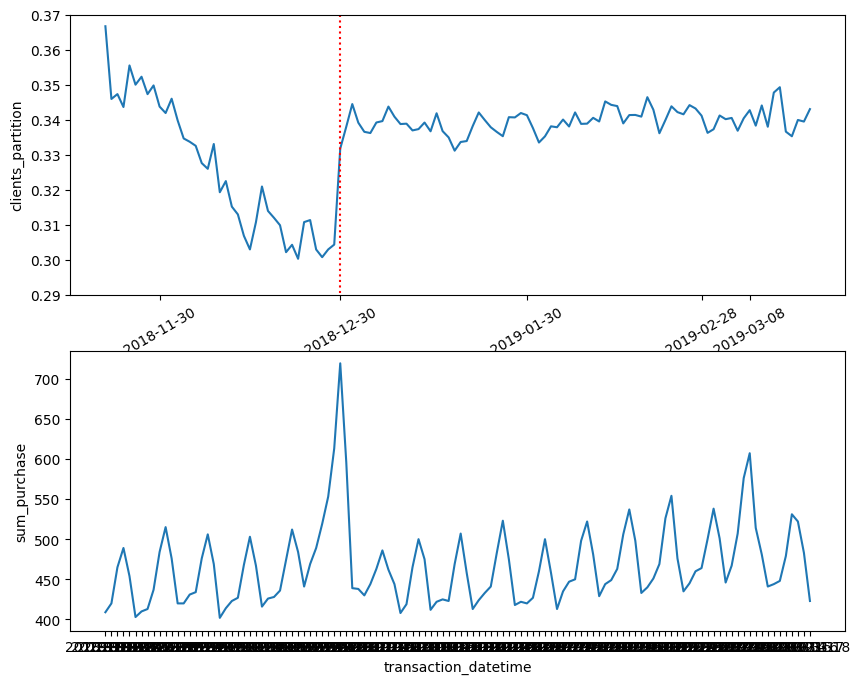

In [144]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
ax = sns.lineplot(df3, x='transaction_datetime', y='clients_partition')
plt.vlines(x='2018-12-30', ymin=0, ymax=1, color='red', linestyles='dotted')
ax.set_ylim([0.29, 0.37])
plt.xticks(['2018-11-30', '2018-12-30', '2019-01-30', '2019-02-28', '2019-03-08'], rotation=30)
plt.subplot(212)
sns.lineplot(df2, x='transaction_datetime', y='sum_purchase')
plt.show()

In [153]:
df4 = df.groupby(['transaction_datetime', 'client_id']).sum_purchase.sum().reset_index()

In [154]:
df5 = pd.merge(df4[df4.sum_purchase > 3000].groupby('transaction_datetime').client_id.count().reset_index(), 
         df4.groupby('transaction_datetime').client_id.count().reset_index(),
         on='transaction_datetime')

In [155]:
df5.columns = ['transaction_datetime', 'clients_more_3000', 'clients_total']

In [158]:
df5['clients_partition'] = (df5['clients_more_3000'] / df5['clients_total']) * 100

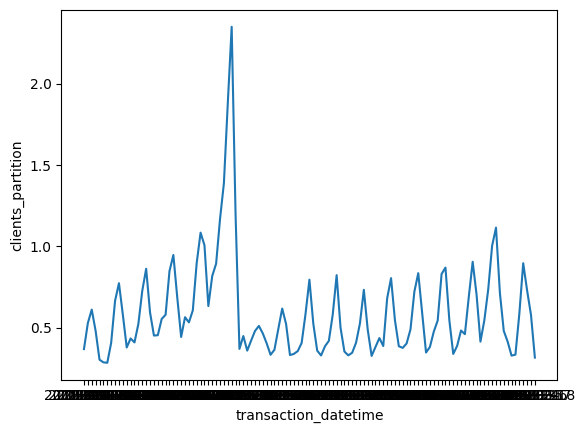

In [159]:
sns.lineplot(df5, x='transaction_datetime', y='clients_partition')
plt.show()

In [165]:
df5['day_of_week'] = df5.transaction_datetime.astype('timestamp[us][pyarrow]').dt.dayofweek

In [1]:
df5.transaction_datetime.astype('timestamp[us][pyarrow]')

NameError: name 'df5' is not defined

In [167]:
df5.sort_values(by='clients_partition', ascending=False)

,transaction_datetime,clients_more_3000,clients_total,clients_partition,day_of_week
38,2018-12-30,1820,77447,2.349994,6
37,2018-12-29,1206,64173,1.879295,5
36,2018-12-28,882,63546,1.387971,4
39,2018-12-31,782,65340,1.196817,0
35,2018-12-27,702,60129,1.167490,3
...,...,...,...,...,...
74,2019-02-04,206,63157,0.326171,0
116,2019-03-18,222,70273,0.315911,0
4,2018-11-26,170,56113,0.302960,0
5,2018-11-27,156,54428,0.286617,1


In [4]:
df = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime'])
df = df.groupby('transaction_datetime').agg({'client_id': ['count', 'nunique']}).reset_index()
df['nunique_ratio'] =  df['client_id']['count'] / df['client_id']['nunique']

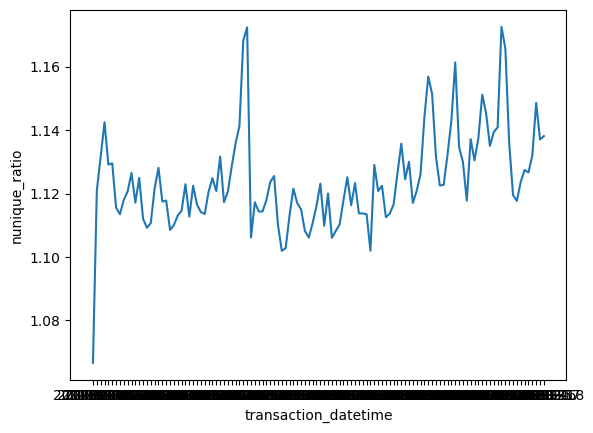

In [11]:
sns.lineplot(df, x='transaction_datetime', y='nunique_ratio')
plt.show()

In [16]:
df = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime'])
temp = df.groupby(['transaction_datetime']).client_id.value_counts().reset_index()
temp = temp[temp['count'] == 1].groupby('transaction_datetime')['count'].sum() / temp.groupby('transaction_datetime')['count'].sum()
temp = temp.reset_index()

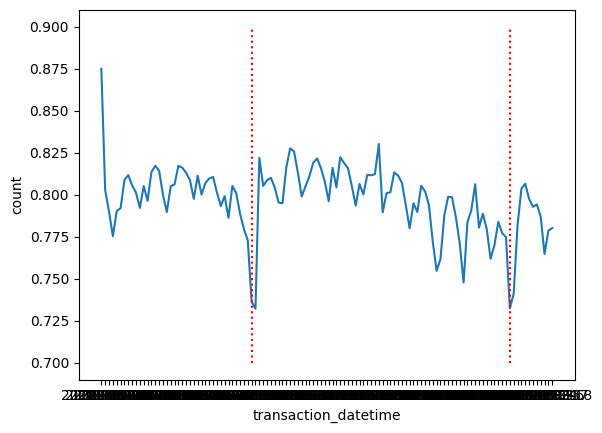

In [39]:
sns.lineplot(temp, x='transaction_datetime', y='count')
plt.vlines(x='2018-12-30', ymin=0.7, ymax=0.9, color='red', linestyles='dotted')
plt.vlines(x='2019-03-07', ymin=0.7, ymax=0.9, color='red', linestyles='dotted')
plt.show()

In [44]:
temp = df.groupby(['transaction_datetime']).client_id.value_counts().reset_index()
temp = temp[temp['count'] > 1].groupby('transaction_datetime')['count'].sum() / temp.groupby('transaction_datetime')['count'].sum()
temp = temp.reset_index()

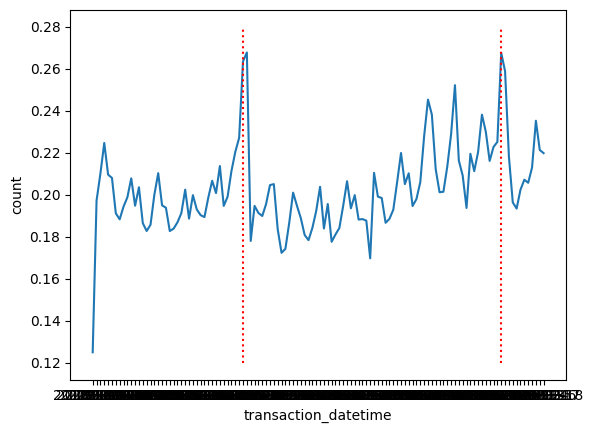

In [46]:
sns.lineplot(temp, x='transaction_datetime', y='count')
plt.vlines(x='2018-12-30', ymin=0.12, ymax=0.28, color='red', linestyles='dotted')
plt.vlines(x='2019-03-07', ymin=0.12, ymax=0.28, color='red', linestyles='dotted')
plt.show()

In [142]:
table = pd.read_csv('purchases_processed.csv', usecols=['sum_purchase', 'transaction_datetime'])

In [144]:
table = table.groupby('transaction_datetime').agg({'sum_purchase': 'sum'}).reset_index()

In [185]:
table_ = table.sort_values(by='sum_purchase', ascending=False).head(10)

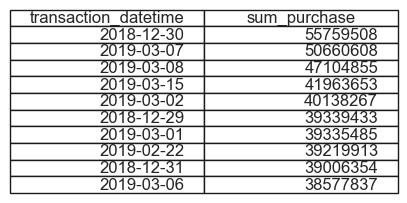

In [148]:
# Render the table
fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=table_.values, colLabels=table_.columns, loc='center')
plt.show()

In [154]:
import dataframe_image as dfi

In [155]:
df_styled = table_.style.background_gradient()

In [186]:
table_.columns = ['Дата', 'Объем продаж']

In [180]:
def transform(x):
    y = str(x)[::-1]
    result = ''
    for i, el in enumerate(y):
        if i % 3 == 0 and i != 0:
            result = ' ' + result
        result = el + result
    return result + ' руб.'

In [187]:
table_['Объем продаж'] = table_['Объем продаж'].apply(lambda x: transform(x))

In [188]:
dfi.export(table_.style.hide(axis = 'index'), "mytable.png", fontsize=14, dpi=500)

In [203]:
table.sum_purchase = np.round(table.sum_purchase / 1000000, 1)

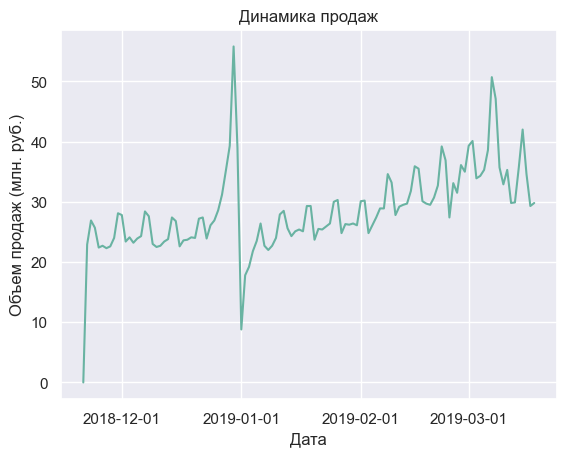

In [206]:
plt.title('Динамика продаж')
sns.lineplot(table, x='transaction_datetime', y='sum_purchase', color='#69b3a2')
plt.xticks(['2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01'])
plt.xlabel('Дата')
plt.ylabel('Объем продаж (млн. руб.)')
plt.savefig("output.jpg", dpi=500)
plt.show()

In [231]:
df = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase'])
df = df.groupby('transaction_datetime').client_id.nunique().reset_index()
df.columns = ['Дата', 'Охват']

In [230]:
def transform2(x):
    y = str(x)[::-1]
    result = ''
    for i, el in enumerate(y):
        if i % 3 == 0 and i != 0:
            result = ' ' + result
        result = el + result
    return result

In [232]:
df = df.sort_values(by='Охват', ascending=False).head(10)
df['Охват'] = df['Охват'].apply(lambda x: transform2(x))
dfi.export(df.style.hide(axis='index'), "mytable.png", fontsize=14, dpi=500)

In [236]:
df = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase'])
df = df.groupby('transaction_datetime').client_id.count().reset_index()
df.columns = ['Дата', 'Количество покупок']
df = df.sort_values(by='Количество покупок', ascending=False).head(10)
df['Количество покупок'] = df['Количество покупок'].apply(lambda x: transform2(x))
dfi.export(df.style.hide(axis='index'), "mytable.png", fontsize=14, dpi=500)

In [237]:
df = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase'])
df = df.groupby('transaction_datetime').sum_purchase.mean().astype(int).reset_index()
df.columns = ['Дата', 'Средний чек']
df = df.sort_values(by='Средний чек', ascending=False).head(10)
df['Средний чек'] = df['Средний чек'].apply(lambda x: transform(x))
dfi.export(df.style.hide(axis='index'), "mytable.png", fontsize=14, dpi=500)

In [238]:
df = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase'])
df = df.groupby(['transaction_datetime', 'client_id']).sum_purchase.sum().groupby('transaction_datetime').mean().astype(int).reset_index()
df.columns = ['Дата', 'Средняя трата на человека']
df = df.sort_values(by='Средняя трата на человека', ascending=False).head(10)
df['Средняя трата на человека'] = df['Средняя трата на человека'].apply(lambda x: transform(x))
dfi.export(df.style.hide(axis='index'), "mytable.png", fontsize=14, dpi=500)

In [239]:
df = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase'])

In [246]:
df = df.groupby('transaction_datetime').agg({'client_id':['count', 'nunique'], 'sum_purchase': ['sum']}).reset_index()

In [247]:
df.head()

transaction_datetime client_id         sum_purchase
                           count nunique          sum
0           2018-11-21        32      30        12287
1           2018-11-22     61181   54584     22939946
2           2018-11-23     65383   57777     26915424
3           2018-11-24     60016   52533     25730608
4           2018-11-25     55527   49177     22362587

In [249]:
clients = pd.read_csv('clients.csv', usecols=['client_id', 'first_issue_date', 'gender'])
clients.first_issue_date = pd.to_datetime(clients.first_issue_date).dt.date

In [259]:
t1 = clients.groupby(['first_issue_date', 'gender']).client_id.count().reset_index()
t1 = pd.merge(t1, clients.groupby(['first_issue_date']).client_id.count().reset_index(), on='first_issue_date')
t1.columns = ['first_issue_date', 'gender', 'client_id', 'client_id_total']
t1['ratio'] = t1.client_id / t1.client_id_total

In [273]:
t1

,first_issue_date,gender,client_id,client_id_total,ratio
0,2017-04-04,U,1,1,1.000000
1,2017-04-09,U,1,1,1.000000
2,2017-04-10,F,330,615,0.536585
3,2017-04-10,M,94,615,0.152846
4,2017-04-10,U,191,615,0.310569
...,...,...,...,...,...
2112,2019-03-14,M,13,67,0.194030
2113,2019-03-14,U,44,67,0.656716
2114,2019-03-15,F,24,88,0.272727
2115,2019-03-15,M,15,88,0.170455


In [269]:
import matplotlib.patches as mpatches

In [ ]:
bar1 = sns.barplot(x="day",  y="total_bill", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="day", y="total_bill", data=smoker, color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='smoker = No')
bottom_bar = mpatches.Patch(color='lightblue', label='smoker = Yes')
plt.legend(handles=[top_bar, bottom_bar])


In [340]:
clients['month'] = pd.to_datetime(clients.first_issue_date).dt.month
clients['year'] =pd.to_datetime(clients.first_issue_date).dt.year

In [ ]:
t1 = clients.groupby(['first_issue_date', 'gender']).client_id.count().reset_index()
t1 = pd.merge(t1, clients.groupby(['first_issue_date']).client_id.count().reset_index(), on='first_issue_date')
t1.columns = ['first_issue_date', 'gender', 'client_id', 'client_id_total']
t1['ratio'] = t1.client_id / t1.client_id_total

In [316]:
table = t1.pivot_table(index='first_issue_date', columns='gender', values='client_id', aggfunc='sum').fillna(0).astype(int).reset_index()
table['total'] = table.F + table.M + table.U

table.F = table.F / table.total
table.M = table.M / table.total
table.U = table.U / table.total



In [5]:
clients = pd.read_csv('clients.csv', usecols=['client_id', 'first_issue_date', 'gender'])
clients.first_issue_date = pd.to_datetime(clients.first_issue_date).dt.date

clients['month'] = pd.to_datetime(clients.first_issue_date).dt.month
clients['year'] =pd.to_datetime(clients.first_issue_date).dt.year

t1 = clients.groupby(['year', 'month', 'gender']).client_id.count().reset_index()
t1 = pd.merge(t1, clients.groupby(['year', 'month']).client_id.count().reset_index(), on=['year', 'month',])
t1.columns = ['year', 'month', 'gender', 'client_id', 'client_id_total']
t1['ratio'] = (t1.client_id / t1.client_id_total) * 100
t1 = t1.sort_values(by=['year', 'month'])
t1['time'] = t1['year'].astype(str) + '/' + t1['month'].astype(str)

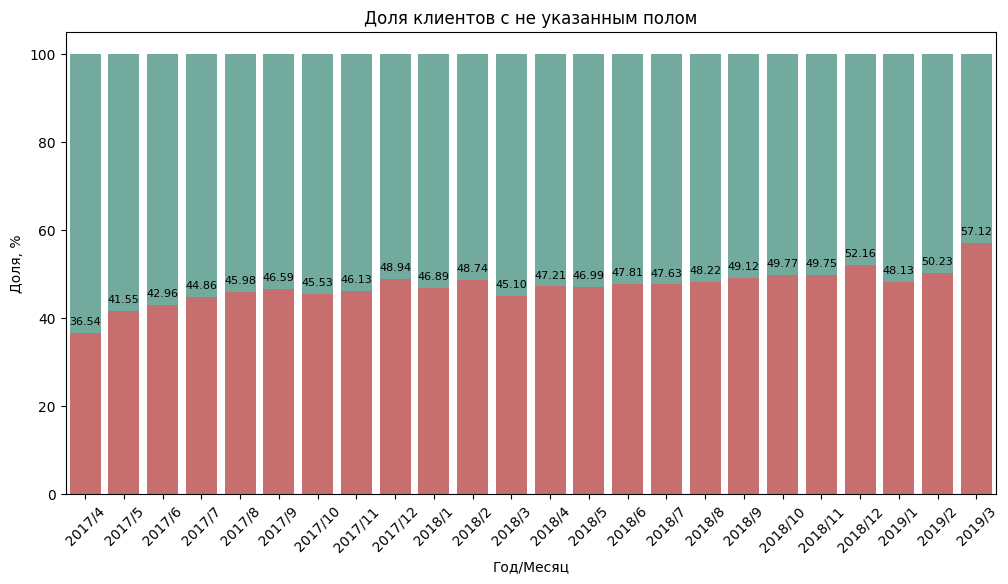

In [24]:
plt.figure(figsize=(12, 6))
plt.title('Доля клиентов с не указанным полом')
sns.barplot(x=t1[t1.gender == 'U'].time, y=np.ones(t1[t1.gender == 'U'].shape[0])* 100, color='#69b3a2')
plots = sns.barplot(t1[t1.gender == 'U'], x='time', y='ratio', color='#D65F5F')


for bar in plots.patches:
    if bar.get_height() != 100:
        plots.annotate(format(bar.get_height(), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                    size=8, xytext=(0, 8),
                    textcoords='offset points')



plt.xlabel('Год/Месяц')
plt.ylabel('Доля, %')
plt.xticks(rotation=45)
plt.savefig("output.jpg", dpi=500)
plt.show()

In [23]:
for el in plots.patches:
    print(el.get_height())

100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
36.542605288932414
41.54807957999447
42.963195973576596
44.85768500948766
45.97799883621048
46.58723650571608
45.53189153584367
46.13180515759313
48.93585243820476
46.892039258451476
48.73608834440514
45.10258826941202
47.209416380578716
46.98819907644946
47.80811487000979
47.63336674462635
48.21920712317151
49.11831346665353
49.77325233165055
49.74727126217859
52.163995437901434
48.13013880293519
50.230198252372446
57.11715763436024


In [374]:
for_piechart = clients.gender.value_counts().reset_index()
for_piechart.gender = ['Неизвестно', "Женщины", "Мужчины"]

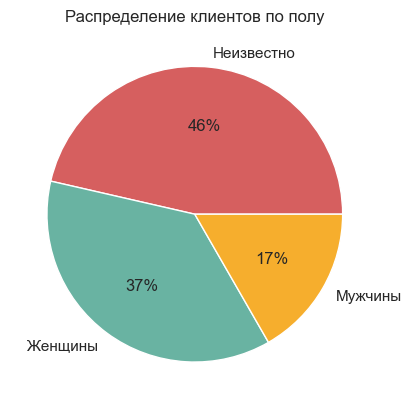

In [383]:
plt.title('Распределение клиентов по полу')
plt.pie(for_piechart['count'], labels =for_piechart.gender, colors =['#D65F5F', '#69b3a2', '#F6AE2D'], autopct='%.0f%%')
plt.savefig("output.jpg", dpi=500)
plt.show()